In [24]:
import pandas as pd

# Load dataset
df = pd.read_csv("all_stocks.csv")

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by ticker and date
df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

# Preview
print(df.head())
print(df.info())


                        Date      Open      High       Low     Close  \
0  1980-12-12 00:00:00-05:00  0.098485  0.098913  0.098485  0.098485   
1  1980-12-15 00:00:00-05:00  0.093775  0.093775  0.093347  0.093347   
2  1980-12-16 00:00:00-05:00  0.086924  0.086924  0.086495  0.086495   
3  1980-12-17 00:00:00-05:00  0.088636  0.089064  0.088636  0.088636   
4  1980-12-18 00:00:00-05:00  0.091206  0.091634  0.091206  0.091206   

      Volume  Dividends  Stock Splits Ticker  
0  469033600        0.0           0.0   AAPL  
1  175884800        0.0           0.0   AAPL  
2  105728000        0.0           0.0   AAPL  
3   86441600        0.0           0.0   AAPL  
4   73449600        0.0           0.0   AAPL  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42665 entries, 0 to 42664
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          42665 non-null  object 
 1   Open          42665 non-null  float64
 2   

C:\Users\hejer\AppData\Local\Temp\ipykernel_13480\1911822711.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


date processing

In [25]:
import pandas as pd
import numpy as np

# Convert Date to datetime and remove timezone (tz-naive)
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_convert(None)

# Extract main date features
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['day_of_week'] = df['Date'].dt.dayofweek   # Monday=0
df['is_month_start'] = df['Date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['Date'].dt.is_month_end.astype(int)

# Optional: cyclical encoding
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

print(df.head())


                 Date      Open      High       Low     Close     Volume  \
0 1980-12-12 05:00:00  0.098485  0.098913  0.098485  0.098485  469033600   
1 1980-12-15 05:00:00  0.093775  0.093775  0.093347  0.093347  175884800   
2 1980-12-16 05:00:00  0.086924  0.086924  0.086495  0.086495  105728000   
3 1980-12-17 05:00:00  0.088636  0.089064  0.088636  0.088636   86441600   
4 1980-12-18 05:00:00  0.091206  0.091634  0.091206  0.091206   73449600   

   Dividends  Stock Splits Ticker  year  month  day  day_of_week  \
0        0.0           0.0   AAPL  1980     12   12            4   
1        0.0           0.0   AAPL  1980     12   15            0   
2        0.0           0.0   AAPL  1980     12   16            1   
3        0.0           0.0   AAPL  1980     12   17            2   
4        0.0           0.0   AAPL  1980     12   18            3   

   is_month_start  is_month_end     month_sin  month_cos   dow_sin   dow_cos  
0               0             0 -2.449294e-16        1.

#ENCODE

In [26]:
from sklearn.preprocessing import LabelEncoder

# Fit the encoder on the Ticker column
encoder = LabelEncoder()
df['Ticker_encoded'] = encoder.fit_transform(df['Ticker'])

# See the mapping
mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print("Ticker -> Numeric label mapping:")
print(mapping)

# Preview a few rows


Ticker -> Numeric label mapping:
{'AAPL': 0, 'GOOG': 1, 'IBM': 2, 'MSFT': 3}


In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df[num_cols] = scaler.fit_transform(df[num_cols])


Define the window size

In [28]:
window_size = 30  # use past 30 days to predict the next day


In [29]:
import numpy as np

def create_time_windows(df, window_size=30):
    X, y = [], []
    
    # Select features including ticker and cyclical time features
    feature_cols = ['Open','High','Low','Close','Volume',
                    'Ticker_encoded','month_sin','month_cos','dow_sin','dow_cos']
    
    features = df[feature_cols].values
    
    for i in range(window_size, len(features)):
        X.append(features[i-window_size:i])  # past N days
        y.append(features[i, 3])  # Close is at index 3
    
    return np.array(X), np.array(y)

# Apply per ticker and combine
X_all, y_all = [], []

for ticker, group in df.groupby('Ticker'):
    group = group.sort_values('Date')
    X, y = create_time_windows(group, window_size)
    X_all.append(X)
    y_all.append(y)

# Combine all tickers into one dataset
X = np.concatenate(X_all)
y = np.concatenate(y_all)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (42545, 30, 10)
y shape: (42545,)


42545 → number of samples (sliding windows)

30 → window size = each sample contains 30 past days

10 → number of features per day:

In [30]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (34036, 30, 10)
X_test: (8509, 30, 10)
y_train: (34036,)
y_test: (8509,)


In [31]:
import torch
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [44]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)


In [45]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.fc = nn.Linear(hidden_size2, 1)
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size=X_train.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")


Epoch 1/20, Train Loss: 0.010518
Epoch 2/20, Train Loss: 0.010096
Epoch 3/20, Train Loss: 0.009702
Epoch 4/20, Train Loss: 0.009316
Epoch 5/20, Train Loss: 0.008904
Epoch 6/20, Train Loss: 0.008434
Epoch 7/20, Train Loss: 0.007868
Epoch 8/20, Train Loss: 0.007160
Epoch 9/20, Train Loss: 0.006250
Epoch 10/20, Train Loss: 0.005065
Epoch 11/20, Train Loss: 0.003558
Epoch 12/20, Train Loss: 0.001893
Epoch 13/20, Train Loss: 0.000680
Epoch 14/20, Train Loss: 0.000259
Epoch 15/20, Train Loss: 0.000166
Epoch 16/20, Train Loss: 0.000127
Epoch 17/20, Train Loss: 0.000102
Epoch 18/20, Train Loss: 0.000084
Epoch 19/20, Train Loss: 0.000070
Epoch 20/20, Train Loss: 0.000059


In [48]:
model.eval()
y_pred_list = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch).squeeze().cpu().numpy()
        y_pred_list.extend(y_pred)

y_pred_list = np.array(y_pred_list)


In [49]:
# Only inverse the Close column
y_pred_real = scaler.inverse_transform(
    np.concatenate([
        np.zeros((len(y_pred_list), 3)),  # dummy Open, High, Low
        y_pred_list.reshape(-1,1),
        np.zeros((len(y_pred_list), 1))   # dummy Volume
    ], axis=1)
)[:, 3]

y_test_real = scaler.inverse_transform(
    np.concatenate([
        np.zeros((len(y_test), 3)),
        y_test.reshape(-1,1),
        np.zeros((len(y_test), 1))
    ], axis=1)
)[:, 3]


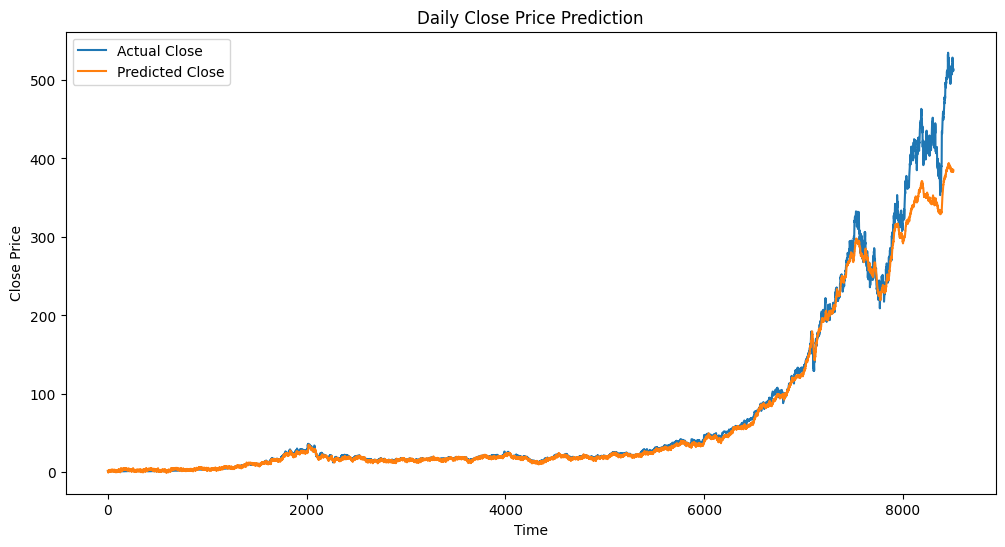

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_real, label='Actual Close')
plt.plot(y_pred_real, label='Predicted Close')
plt.title('Daily Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [51]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_real, y_pred_real)
print("R² Score (proxy for accuracy):", r2)


R² Score (proxy for accuracy): 0.9700414668808303


In [52]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_real, y_pred_real)
print("MSE:", mse)


MSE: 408.8465927649777


In [54]:
import torch

# Save the model
torch.save(model.state_dict(), "second_model_lstm.pth")


In [55]:
import pickle

with open("second_model_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


In [71]:
# Check shapes
print("X shape:", X.shape)  # should be (num_samples, window_size, num_features)
print("y shape:", y.shape)  # should be (num_samples,)

# Look at the first sample of X and corresponding y
print("\nFirst window of features (X[0]):")
print(X[0])

print("\nTarget corresponding to first window (y[0]):")
print(y[0])

# Check feature names and types
feature_cols = ['Open','High','Low','Close','Volume','Ticker_encoded','month_sin','month_cos','dow_sin','dow_cos']
print("\nFeature columns:", feature_cols)

# Optional: quick statistics
print("\nFeature statistics:")
for i, col in enumerate(feature_cols):
    print(f"{col}: min={X[:,:,i].min()}, max={X[:,:,i].max()}, mean={X[:,:,i].mean():.4f}")
    
print("\nTarget (Close) statistics:")
print(f"min={y.min()}, max={y.max()}, mean={y.mean():.4f}")


X shape: (42545, 30, 10)
y shape: (42545,)

First window of features (X[0]):
[[ 1.08925961e-04  1.09654984e-04  1.14510233e-04  1.13710627e-04
   6.31981003e-02  0.00000000e+00 -2.44929360e-16  1.00000000e+00
  -4.33883739e-01 -9.00968868e-01]
 [ 1.00428764e-04  1.00388979e-04  1.04833952e-04  1.04101913e-04
   2.36989104e-02  0.00000000e+00 -2.44929360e-16  1.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 8.80677369e-05  8.80328480e-05  9.19307327e-05  9.12887954e-05
   1.42459064e-02  0.00000000e+00 -2.44929360e-16  1.00000000e+00
   7.81831482e-01  6.23489802e-01]
 [ 9.11576462e-05  9.18937084e-05  9.59625318e-05  9.52924411e-05
   1.16472357e-02  0.00000000e+00 -2.44929360e-16  1.00000000e+00
   9.74927912e-01 -2.22520934e-01]
 [ 9.57938359e-05  9.65280507e-05  1.00802083e-04  1.00098198e-04
   9.89667945e-03  0.00000000e+00 -2.44929360e-16  1.00000000e+00
   4.33883739e-01 -9.00968868e-01]
 [ 1.05836046e-04  1.06566293e-04  1.11284782e-04  1.10507699e-04
   6.55251329e-03  0.0